In [1]:
import tweepy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
consumer_key = 'xxx'
consumer_secret = 'xxx'
access_token = 'xxx'
access_token_secret = 'xxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth=auth, wait_on_rate_limit=True)

## Terminology
* **Friends** - we refer to "friends" as the Twitter users that a specific user follows (e.g., following). Therefore, the GET friends/ids endpoint returns a collection of user IDs that the specified user follows.  

* **Followers** - refers to the Twitter users that follow a specific user. Therefore, making a request to the GET followers/ids endpoint returns a collection of user IDs for every user following the specified user.

In [15]:
def fetch_contacts(api, user_list, contacts):
    """
        Obtains friends and followers of users from a given list of users.

        - if contacts = 'friends' fetches the profiles followed by each user in the list;
        - if contacts = 'followers' fetches the profiles following each user in the list;
        - if contacts = 'all', performs both operations.

        The contacts are stored in a DataFrame, where each row represents an instance of a relationship
        i.e. the profile in the 'source' col follows the profile in the 'target' col.
    
    :param List[twitter.Api] api: a list with one or more Twitter API instances;
    :param list user_list: a list of userIDs to fetch friends and followers from;
    :param str contacts: the kind of contacts wanted for each user in the list;
    :return: a DataFrame with friends, followers or both for each userID. 
    """
    df = pd.DataFrame(columns=['source','target']) # empty df

    if contacts == 'friends':
    # fetching friends
        for userID in user_list:
            friends = []
            friends_list = []
            # fetching the user
            user = api.get_user(user_id=userID)
            # fetching the friends_count
            friends_count = user.friends_count
            try:
                for page in tweepy.Cursor(api.get_friend_ids, user_id=userID).pages():
                    friends.extend(page)
                    print(user.screen_name, 'follows', len(friends), 'profiles')
                    if friends_count >= 5000: #Only take first 5000 friends
                        break
            except tweepy.TweepyException:
                print("error")
                continue
            friends_list.append(friends)
            temp1 = pd.DataFrame(columns=['source', 'target'])
            temp1['target'] = friends_list[0] # set the list of friends as the target column
            temp1['source'] = userID # set the user ID as the source 
            df = df.append(temp1)

    elif contacts == 'followers':
    # fetching followers
        for userID in user_list:
            followers = []
            follower_list = []
            # fetching the user
            user = api.get_user(user_id=userID)
            # fetching the followers_count
            followers_count = user.followers_count
            try:
                for page in tweepy.Cursor(api.get_follower_ids, user_id=userID).pages():
                    followers.extend(page)
                    print(user.screen_name, 'is followed by', len(followers), 'profiles')
                    if followers_count >= 5000: #Only take first 5000 followers
                        break
            except tweepy.TweepyException:
                print("error")
                continue
            follower_list.append(followers)
            temp2 = pd.DataFrame(columns=['source', 'target'])
            temp2['source'] = follower_list[0] # set the list of followers as the source column
            temp2['target'] = userID # set the user ID as the target (user is followed by followers)
            df = df.append(temp2)
            
    elif contacts == 'all':
    # fetching friends
        for userID in user_list:
            friends = []
            friends_list = []
            # fetching the user
            user = api.get_user(user_id=userID)
            # fetching the friends_count
            friends_count = user.friends_count
            try:
                for page in tweepy.Cursor(api.get_friend_ids, user_id=userID).pages():
                    friends.extend(page)
                    if friends_count >= 5000: #Only take first 5000 friends
                        break
            except tweepy.TweepyException:
                print("error")
                continue
            friends_list.append(friends)
            temp1 = pd.DataFrame(columns=['source', 'target'])
            temp1['target'] = friends_list[0] # set the list of friends as the target column
            temp1['source'] = userID # set the user ID as the source 
            df = df.append(temp1)
    # fetching followers
        for userID in user_list:
            followers = []
            follower_list = []
            # fetching the user
            user = api.get_user(user_id=userID)
            # fetching the followers_count
            followers_count = user.followers_count
            try:
                for page in tweepy.Cursor(api.get_follower_ids, user_id=userID).pages():
                    followers.extend(page)
                    print(user.screen_name, 'follows', len(friends), 'profiles \n', 
                        user.screen_name, 'is followed by', len(followers), 'profiles')
                    if followers_count >= 5000: #Only take first 5000 followers
                        break
            except tweepy.TweepyException:
                print("error")
                continue
            follower_list.append(followers)
            temp2 = pd.DataFrame(columns=['source', 'target'])
            temp2['source'] = follower_list[0] # set the list of followers as the source column
            temp2['target'] = userID # set the user ID as the target (user is followed by followers)
            df = df.append(temp2)    
    else: 
        raise ValueError("Unknown mode: contacts should be one of 'friends', 'followers', 'all'")
        
    return df   

In [4]:
def fetch_network(api, userID):
    """
        Fetches the network of relationships of a given userID: 
        its friends, followers and their relationships between each other 
    """
    df = pd.DataFrame(columns=['source','target']) # empty df
    
    # fetching friends
    friends = []
    friends_list = []
    # fetching the user
    user = api.get_user(user_id=userID)
    friends_count = user.friends_count
    try:
        for page in tweepy.Cursor(api.get_friend_ids, user_id=userID).pages():
            friends.extend(page)
            print(user.screen_name, 'follows', len(friends), 'profiles')
            if friends_count >= 5000: #Only take first 5000 friends
                break
    except tweepy.TweepyException:
        print("error")
    friends_list.append(friends)
    temp1 = pd.DataFrame(columns=['source', 'target'])
    temp1['target'] = friends_list[0] # set the list of friends as the target column
    temp1['source'] = userID # set the user ID as the source 
    df = df.append(temp1)

    # fetching followers
    followers = []
    follower_list = []
    followers_count = user.followers_count 
    try:
        for page in tweepy.Cursor(api.get_follower_ids, user_id=userID).pages():
            followers.extend(page)
            print(user.screen_name, 'is followed by', len(followers), 'profiles')
            if followers_count >= 5000: #Only take first 5000 followers
                break
    except tweepy.TweepyException:
        print("error")
    follower_list.append(followers)
    temp2 = pd.DataFrame(columns=['source', 'target'])
    temp2['source'] = follower_list[0] # set the list of followers as the source column
    temp2['target'] = userID # set the user ID as the target (user is followed by followers)
    df = df.append(temp2) 
    
    # friends of friends
    for friend_id in temp1['target']:
        friends_of_friends = []
        friends_of_friends_list = []
        # fetching the user
        try:
            user = api.get_user(user_id=friend_id)
        except tweepy.TweepyException:
            continue    
        # fetching the friends_count and followers_count
        friends_of_friends_count = user.friends_count
        try:
            for page in tweepy.Cursor(api.get_friend_ids, user_id=friend_id).pages():
                friends_of_friends.extend(page)
                print(user.screen_name, 'follows', len(friends_of_friends), 'profiles')
                if friends_of_friends_count >= 5000: #Only take first 5000 friends
                    break
        except tweepy.TweepyException:
            print("error")
            continue
        friends_of_friends_list.append(friends_of_friends)
        temp3 = pd.DataFrame(columns=['source', 'target'])
        temp3['target'] = friends_of_friends_list[0] # set the list of friends as the target column
        temp3['source'] = friend_id # set the user ID as the source 
        df = df.append(temp3)
    
    # friends of followers
    for follower_id in temp2['source']:
        friends_of_followers = []
        friends_of_followers_list = []
        # fetching the user
        try:
            user = api.get_user(user_id=follower_id)
        except tweepy.TweepyException:
            continue    
        # fetching the friends_count and followers_count
        friends_of_followers_count = user.followers_count
        try:
            for page in tweepy.Cursor(api.get_friend_ids, user_id=follower_id).pages():
                friends_of_followers.extend(page)
                print(user.screen_name, 'follows', len(friends_of_followers), 'profiles')
                if friends_of_followers_count >= 5000: #Only take first 5000 friends
                    break
        except tweepy.TweepyException:
            print("error")
            continue
        friends_of_followers_list.append(friends_of_followers)
        temp4 = pd.DataFrame(columns=['source', 'target'])
        temp4['target'] = friends_of_followers_list[0] # set the list of friends as the target column
        temp4['source'] = follower_id # set the user ID as the source 
        df = df.append(temp4)
    return df

## Testing

In [5]:
# getting user_id given the screen name 
me = api.get_user(screen_name = 'DylanTartarini')
me.id

1013061841524871168

In [6]:
user_list=['1013061841524871168']

In [16]:
my_contacts = fetch_contacts(api=api, user_list=user_list, contacts='all')
my_contacts.shape

DylanTartarini follows 272 profiles 
 DylanTartarini is followed by 16 profiles


(288, 2)

In [8]:
my_contacts

,source,target
0,1013061841524871168,80593827
1,1013061841524871168,1236450528516866049
2,1013061841524871168,1280297900
3,1013061841524871168,23430560
4,1013061841524871168,1333781645409718272
...,...,...
11,968819223727411200,1013061841524871168
12,929056517009166336,1013061841524871168
13,764490770934038528,1013061841524871168
14,2351369450,1013061841524871168


In [42]:
G = nx.from_pandas_edgelist(df=my_contacts ,source='source',target='target', edge_attr=None, create_using=nx.DiGraph())

In [45]:
print(nx.info(G))

DiGraph with 285 nodes and 288 edges


C:\Users\Dylan\AppData\Local\Temp/ipykernel_3764/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [43]:
G.number_of_nodes()

285

In [44]:
G.number_of_edges()

288

In [10]:
def draw_graph(G, pos_nodes, node_names={}, node_size=50, plot_weight=False):
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='gray', arrowsize=10)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)

    if plot_weight:
        pos_attrs = {}
        for node, coords in pos_nodes.items():
            pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
        nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
        edge_labels=dict([((a,b,),d["weight"]) for a,b,d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos_nodes, edge_labels=edge_labels)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])

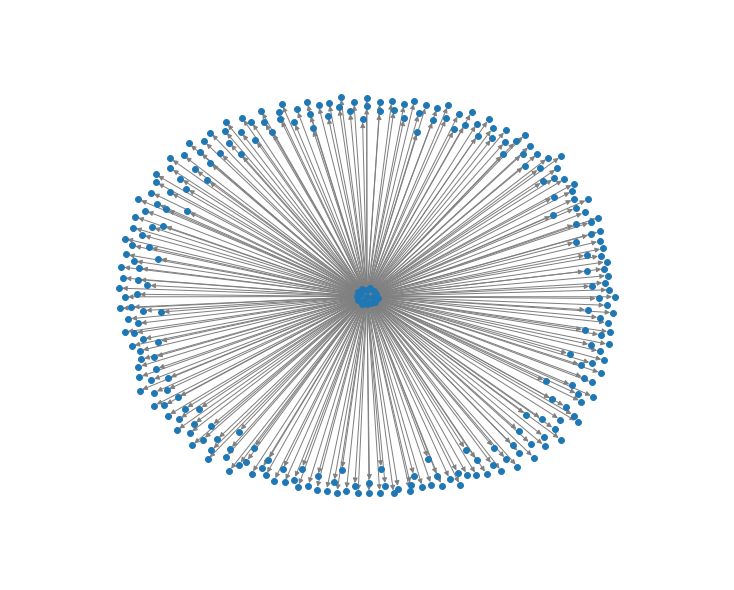

In [46]:
draw_graph(G, pos_nodes=nx.spring_layout(G), node_size=35)

In [40]:
from pyvis.network import Network
nt = Network(directed=True)
# populates the nodes and edges data structures
nt.from_nx(G)
nt.barnes_hut()
#nt.show_buttons()
nt.show('my_contacts.html')

In [12]:
edges = nx.to_pandas_edgelist(G)
edges

,source,target
0,1013061841524871168,80593827
1,1013061841524871168,1236450528516866049
2,1013061841524871168,1280297900
3,1013061841524871168,23430560
4,1013061841524871168,1333781645409718272
...,...,...
283,943473204118671361,1013061841524871168
284,968819223727411200,1013061841524871168
285,929056517009166336,1013061841524871168
286,764490770934038528,1013061841524871168


In [13]:
edges['source'].unique()

array(['1013061841524871168', 1280297900, 1101511258254254081,
       967695584210640896, 254604351, 748492600408145920,
       1199331702927175680, 129443586, 971816547898490881,
       1009823901441036289, 455250598, 305569332, 943473204118671361,
       968819223727411200, 929056517009166336, 764490770934038528,
       2351369450], dtype=object)

In [14]:
edges['target'].unique()

array([80593827, 1236450528516866049, 1280297900, 23430560,
       1333781645409718272, 117728351, 507938501, 637018529, 543382485,
       1182668451552382976, 61765111, 18022037, 1557514573,
       1059361525109010433, 395183088, 1101511258254254081,
       1300916262369984515, 420332560, 104485125, 454423746, 404064077,
       4833517913, 340418291, 14575613, 86936133, 1240690942904066049,
       3270678680, 68746721, 216939636, 775449094739197953, 83466368,
       1508528078854795271, 1076526138736951298, 778764142412984320,
       11970912, 55862897, 1398036206869483521, 14711301, 187515095,
       3099188981, 1279106879579439104, 2197265034, 923010104479252480,
       6566922, 3167734591, 13334762, 128700677, 1681744826,
       1138857077722558464, 611168477, 1447705451114778625, 3698212043,
       4398626122, 4783690002, 33838201, 2651181366, 1034844617261248512,
       1001344387102728194, 297884272, 29507504, 20167623, 80422885,
       254107028, 776585502606721024, 99215393009